<a href="https://colab.research.google.com/github/sasha-kurzenev/yandex_practicum/blob/main/AB_tests/14_AB_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A / B  Тестирование 

##  Постановка задачи

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:
- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

## Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

# Загрузим необходимые модули

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import plotly.express as px
import math as mth
import re
import scipy.stats as stats
import warnings
import requests

from plotly import graph_objects as go
#from google.colab import files
from matplotlib import pyplot as plt
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
from datetime import datetime, timedelta

register_matplotlib_converters()
warnings.filterwarnings("ignore")

# Загрузим датасеты из файлов

In [ ]:
try:
    print('Загружаем локально...')
    final_ab_events = pd.read_csv('/final_ab_events.csv')
    ab_project_marketing_events = pd.read_csv('/ab_project_marketing_events.csv')
    final_ab_new_users = pd.read_csv('/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('/final_ab_participants.csv')    
except:
    print('Локально не нашли, загружаем с сервера...')
    final_ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    ab_project_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    final_ab_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv') 
print('Done')

Загружаем локально...
Локально не нашли, загружаем с сервера...
Done


# Исследуем данные

In [ ]:
print(final_ab_events.info())
print('Количество NAN final_ab_events',final_ab_events.isna().sum())
print('Количество дублей final_ab_events',final_ab_events.duplicated().sum())
print()
print(ab_project_marketing_events.info())
print('Количество NAN ab_project_marketing_events',ab_project_marketing_events.isna().sum())
print('Количество дублей ab_project_marketing_events',ab_project_marketing_events.duplicated().sum())
print()
print(final_ab_new_users.info())
print('Количество NAN final_ab_new_users',final_ab_new_users.isna().sum())
print('Количество дублей final_ab_new_users',final_ab_new_users.duplicated().sum())
print('Количество дублей final_ab_new_users',final_ab_new_users.duplicated(['user_id']).sum())

print()
print(final_ab_participants.info())
print('Количество NAN final_ab_participants',final_ab_participants.isna().sum())
print('Количество дублей final_ab_participants',final_ab_participants.duplicated().sum())
print()
print('Начало измериняия final_ab_events',final_ab_events['event_dt'].min())
print('Окончание измериняия final_ab_events',final_ab_events['event_dt'].max())
print()
print('Начало измериняия final_ab_new_users',final_ab_new_users['first_date'].min())
print('Окончание измериняия final_ab_new_users',final_ab_new_users['first_date'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
Количество NAN final_ab_events user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Количество дублей final_ab_events 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
Количество NAN ab_project_mar

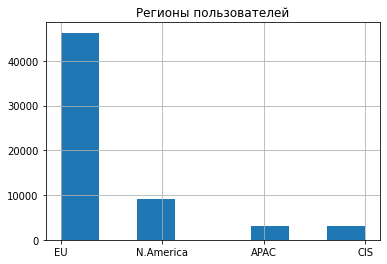

In [ ]:
plt.title('Регионы пользователей')
final_ab_new_users['region'].hist(bins=final_ab_new_users['region'].nunique()*2);

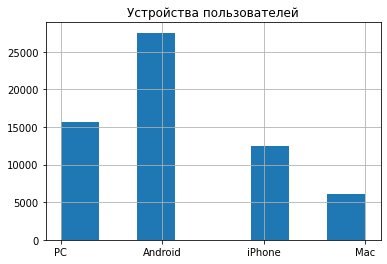

In [ ]:
plt.title('Устройства пользователей')
final_ab_new_users['device'].hist(bins=final_ab_new_users['device'].nunique()*2);

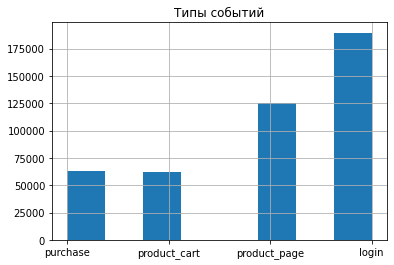

In [ ]:
plt.title('Типы событий')
final_ab_events['event_name'].hist(bins=final_ab_events['event_name'].nunique()*2);

### Вывод 

Нужно привести даты в правильный формат
final_ab_new_users['details'] есть nan , но это сказано в условиях, что это дополнительная информация. которой может не быть

## Даты в правильный формат

In [ ]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

## Создадим профиль пользователей

In [ ]:
log = final_ab_events.merge(final_ab_participants, on='user_id')
log = log.merge(final_ab_new_users, on='user_id')

# Колонка lifetime события
log['event_lifetime'] = (log['event_dt'] - log['first_date']).dt.days

# Оцените корректность проведения теста. Обратите внимание на:

## Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.




In [ ]:
print('Какие тесты есть в датафрейме',log['ab_test'].unique())

Какие тесты есть в датафрейме ['interface_eu_test' 'recommender_system_test']


### - Название теста: `recommender_system_test`; ✔️ ОК

In [ ]:
print('Какие группы есть в датафрейме',log['group'].unique())

Какие группы есть в датафрейме ['B' 'A']


### - группы: А — контрольная, B — новая платёжная воронка; ✔️ OK

In [ ]:
print('Начало действий',log['event_dt'].min())
print('Окончание действий',log['event_dt'].max())
print('Начало регистрайии пользователей',log['first_date'].min())
print('Окончание регистрайии пользователей',log['first_date'].max())

Начало действий 2020-12-07 00:02:48
Окончание действий 2020-12-30 18:28:55
Начало регистрайии пользователей 2020-12-07 00:00:00
Окончание регистрайии пользователей 2020-12-23 00:00:00


In [ ]:
n_users = final_ab_new_users['user_id'].nunique()
ue_users = log.query('region=="EU"')['user_id'].nunique()
print(n_users ,'пользователей')
print(ue_users,'Пользователей из Европы в тесте')
print( 'Процент из Европы',round(ue_users/n_users *100,2))

61733 пользователей
13444 Пользователей из Европы в тесте
Процент из Европы 21.78


In [ ]:
print('Какие группы есть в датафрейме',log['region'].unique())

Какие группы есть в датафрейме ['EU' 'N.America' 'CIS' 'APAC']


Нам для теста нужны будут только из Европы

Посмотрим на пользователей, которые
- из европы
- зарегистрировались до 21 декабря
- учавствуют в тесте recommender_system_test

In [ ]:
log_temp = log

In [ ]:
#n_users = log_temp['user_id'].nunique()
n_users = final_ab_new_users.query('region=="EU"').query('first_date<="2020-12-21"').query('first_date>="2020-12-07"')['user_id'].nunique()
good_users = log_temp.query('first_date<="2020-12-21"').query('ab_test=="recommender_system_test"').query('region=="EU"')['user_id'].nunique()
print(n_users ,'пользователей')
print(good_users ,' пользователей удовлетворяющих условию теста')
print( 'Процент таких пользователей',round(good_users/n_users *100,2))

42340 пользователей
3481  пользователей удовлетворяющих условию теста
Процент таких пользователей 8.22


In [ ]:
log_temp = log_temp.query('first_date<="2020-12-21"').query('region=="EU"')
both_test_users = log_temp.pivot_table(index=['user_id'], values='ab_test', aggfunc='nunique')
both_g_users = log_temp.pivot_table(index=['user_id'], values='group', aggfunc='nunique')
print('Количество пользователей',log['user_id'].nunique())
print('Пользователи в нескольких тестах',len(both_test_users[both_test_users['ab_test'] > 1]))
print('Пользователи в нескольких группах',len(both_g_users[both_g_users['group'] > 1]))

Количество пользователей 13638
Пользователи в нескольких тестах 887
Пользователи в нескольких группах 441


Даже если брать пользователей зарегистрировавшихся до 21 и из европы, всеравно много пользователей из нескольких групп и нескольких тестов.
Такое исследование будет некорректным.

### - ожидаемое количество участников теста: > 6000. ❌ **Not OK**
### - аудитория: 15% новых пользователей из региона EU;  ✔️ OK

### Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

In [ ]:
ev_dt_max = log['event_dt'].max()
ev_dt_min = log['event_dt'].min()

for i , j in ab_project_marketing_events[ab_project_marketing_events['regions'].str.contains(r'\bEU')].iterrows():
   if((j['start_dt']<ev_dt_min)and(j['finish_dt']>ev_dt_min))\
       or ((j['start_dt']<ev_dt_max)and(j['finish_dt']>ev_dt_max))\
       or ((j['start_dt']>ev_dt_min)and(j['finish_dt']<ev_dt_max)):
       print('Акция ', j['name'] , j['start_dt'], j['finish_dt'], 'попадает на период тестирования')

Акция  Christmas&New Year Promo 2020-12-25 00:00:00 2021-01-03 00:00:00 попадает на период тестирования


На веремя проведелния теста в Европе приходиться акция  Christmas&New Year Promo. Но эта акция скорее всего влияет на обе группы исследуемых одинаково, поэтому этим фактом можно пренебречь

##  Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

In [ ]:
both_test_users = log.pivot_table(index=['user_id'], values='ab_test', aggfunc='nunique')
both_g_users = log.pivot_table(index=['user_id'], values='group', aggfunc='nunique')
print('Количество пользователей',log['user_id'].nunique())
print('Пользователи в нескольких тестах',len(both_test_users[both_test_users['ab_test'] > 1]))
print('Пользователи в нескольких группах',len(both_g_users[both_g_users['group'] > 1]))

Количество пользователей 13638
Пользователи в нескольких тестах 887
Пользователи в нескольких группах 441


Есть пользователи , которые учавствуют сразу в двух тестах. Попробуем убрать таких пользователей

Посмотрим, что получилось

In [ ]:
both_test_users = log.query('ab_test=="recommender_system_test"').pivot_table(index=['user_id'], values='ab_test', aggfunc='nunique')
both_g_users = log.query('ab_test=="recommender_system_test"').pivot_table(index=['user_id'], values='group', aggfunc='nunique')
print('Количество пользователей',log['user_id'].nunique())
print('Пользователи в нескольких тестах',len(both_test_users[both_test_users['ab_test'] > 1]))
print('Пользователи в нескольких группах',len(both_g_users[both_g_users['group'] > 1]))

Количество пользователей 13638
Пользователи в нескольких тестах 0
Пользователи в нескольких группах 0


Есть пользователи в нескольких тестах и в нескольких группах. Но если оставить только тех пользователей которые принимают участие в нашем тесте то пользователей в нескольких группах тоже не будет.

## Проверьте равномерность распределения по тестовым группам и правильность их формирования.

In [ ]:
users_g = log.pivot_table(index=['group'], values='user_id', aggfunc='count')
fig = px.pie(users_g, values='user_id', width=400, names=users_g.index, title='Разделение по группам')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show();

Пользователи по гурппам распределены равномерно

# Проведите исследовательский анализ данных:

## Корректируем данные

Оставим только recommender_system_test
Оставим пользователей зарегистрировавшихся по условиям эксперимента
Оставим события только в течении 14 дней после регистрации и только полтзователей из Европы

In [ ]:
# Оставим только recommender_system_test
log = log.query('ab_test=="recommender_system_test"')

<div class="alert alert-info"> <b>Комментарии студента: </b>Вот тут забыл исправить </div>

In [ ]:
# Оставим пользователей зарегистрировавшихся по условиям эксперимента
log = log.query('first_date<="2020-12-21"').query('region=="EU"')

In [ ]:
# Оставим события только в течении 14 дней после регистрации
log = log.query('event_lifetime<=14')

In [ ]:
# КОД РЕВЬЮЕРА

log['user_id'].nunique()


3481

## Количество событий на пользователя одинаково распределены в выборках?

In [ ]:
log_users = log.pivot_table(index=['user_id'], values=['event_dt'], aggfunc='count')
log_users_a = log.query('group=="A"').pivot_table(index=['user_id'], values=['event_dt'], aggfunc='count')
log_users_b = log.query('group=="B"').pivot_table(index=['user_id'], values=['event_dt'], aggfunc='count')


In [ ]:
fig = px.box(log_users['event_dt'],  height=400,)
fig.update_layout(title='Событий на пользователя',
                   xaxis_title='Все пользователи',
                   yaxis_title='Событий',
                   )
fig.show();

In [ ]:
fig = px.box(log_users_a['event_dt'],  height=400,)
fig.update_layout(title='Событий на пользователя',
                   xaxis_title='A пользователи',
                   yaxis_title='Событий',
                   )
fig.show();

In [ ]:
fig = px.box(log_users_b['event_dt'],  height=400,)
fig.update_layout(title='Событий на пользователя',
                   xaxis_title='B пользователи',
                   yaxis_title='Событий',
                   )
fig.show();

### Вывод

Медианное количество событий на пользователя в группах не одинаково, В группе А это 6 , в группе Б это 4. Группы неравномерные.


## Как число событий в выборках распределено по дням?

Построим гистограмму по времени

In [ ]:
x0 = log.query('group=="A"')['event_dt']
x1 = log.query('group=="B"')['event_dt']

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0,name='Группа A'))
fig.add_trace(go.Histogram(x=x1,name='Группа B'))

fig.update_traces(opacity=0.75)
fig.update_layout(barmode='group',title='Распределение событий по времени',
                   xaxis_title='Время',yaxis_title='Количество событий', height=600)
fig.show()

### Вывод

На графиках видно что группа Б распределена равномерно, а группа А в середине тестирования имеет всплеск.

## Как меняется конверсия в воронке в выборках на разных этапах?

In [ ]:
funnel_ab = log.pivot_table(index=['event_name'], values='user_id', aggfunc='nunique')
funnel_a = log.query('group=="A"').pivot_table(index=['event_name'], values='user_id', aggfunc='nunique')
funnel_b = log.query('group=="B"').pivot_table(index=['event_name'], values='user_id', aggfunc='nunique')
new_index = ['login', 'product_page', 'product_cart', 'purchase']
funnel_ab =funnel_ab.reindex(new_index)
funnel_a = funnel_a.reindex(new_index)
funnel_b = funnel_b.reindex(new_index)

fig = go.Figure(go.Funnel(
    y = funnel_ab.index, 
    x = funnel_ab['user_id'],
    textinfo = "value+percent initial + percent previous",
    marker = {"color": ["deepskyblue", "deepskyblue", "deepskyblue"]},
    ))
fig.update_layout(title="Воронка для А и В")
fig.show()

In [ ]:
fig = go.Figure(go.Funnel(
    y = funnel_a.index, 
    x = funnel_a['user_id'],
    textinfo = "value+percent initial + percent previous",
    marker = {"color": ["lightsalmon", "lightsalmon", "lightsalmon"]},
    ))
fig.update_layout(title="Воронка для А ")
fig.show()

In [ ]:
fig = go.Figure(go.Funnel(
    y = funnel_b.index, 
    x = funnel_b['user_id'],
    textinfo = "value+percent initial + percent previous",
    marker = {"color": ["tan", "tan", "tan"]},
    ))
fig.update_layout(title="Воронка для В")
fig.show()

### Вывод 

Воронки продаж немного странные, количество продаж больше чем добавлений в корзину, значит есть какой то способ купить, без добавления товара в корзину.

## Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?


Почему то покупок меньше чем добавлений в корзину. Очевидно есть способ покупки не добавляя товар в корзину.

# Оцените результаты A/B-тестирования

In [ ]:
funnel_ab = funnel_ab.merge(funnel_a, on='event_name').merge(funnel_b, on='event_name').reset_index()
funnel_ab.columns = ['event','a_b','a','b']

for i in funnel_ab.index:
    if i>0:
        funnel_ab.loc[[i], ['a_b_CR']] = funnel_ab.loc[i]['a_b'] / funnel_ab.loc[0]['a_b'] *100
        funnel_ab.loc[[i], ['a_CR']] = funnel_ab.loc[i]['a'] / funnel_ab.loc[0]['a'] *100
        funnel_ab.loc[[i], ['b_CR']] = funnel_ab.loc[i]['b'] / funnel_ab.loc[0]['b'] *100
    else:
        funnel_ab.loc[[i], ['a_b_CR']] = 100
        funnel_ab.loc[[i], ['a_CR']] = 100
        funnel_ab.loc[[i], ['b_CR']] = 100        
        
print(funnel_ab)  

          event   a_b     a    b      a_b_CR        a_CR        b_CR
0         login  3480  2604  876  100.000000  100.000000  100.000000
1  product_page  2178  1685  493   62.586207   64.708141   56.278539
2  product_cart  1026   782  244   29.482759   30.030722   27.853881
3      purchase  1082   833  249   31.091954   31.989247   28.424658


### Вывод 

Конверсия даже уменьшилась в группе Б. И естественно нигде не достигла прироста в 10%

## Гипотеза

Нулевая гипотеза: конверсия пользователей из группы A и группы B одинаковая 

## Проверьте статистическую разницу долей z-критерием.

In [ ]:
# Уровень значимости возьмем 0,05
alpha = .05 

In [ ]:
# процедура сасчитывает статистическую  значимость разницы(взял ее из тренажера)
def z_val(successes,trials):
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('P-value',p_value)
    return p_value

## Проверим воронки

In [ ]:
# Заполняем параметры и вызываем процедуру        
g1 = 'a'
g2 = 'b'
trials = np.array([funnel_ab.loc[0,g1], funnel_ab.loc[0,g2]])
for i in funnel_ab.index:
    if i>0:
        successes = np.array([funnel_ab.loc[i,g1], funnel_ab.loc[i,g2]])
        print()
        print('Группы',g1,g2,'Проверяем событие',funnel_ab.loc[i, 'event'])
        if z_val(successes,trials)  < alpha:
            print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группами разными')       


Группы a b Проверяем событие product_page
P-value 8.195976000324734e-06
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы a b Проверяем событие product_cart
P-value 0.2215941567364419
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группами разными

Группы a b Проверяем событие purchase
P-value 0.04864766695042433
Отвергаем нулевую гипотезу: между группами есть значимая разница


# Итог 


Был проведен аб тест, корректность его проведения вызывает сомнение.  Он проходит во время акции, также некоторые пользователи, учавствующие в тесте, учавствовали в другом тесте. Также количество учавствующих пользователей меньше необходимого 6000 и процент от всей аудитории тоже меньше 15%

Акция влияла сразу на всех пользователей и, ей можно пренебречь.

Исходя из теста

- По событию product_page между группами есть значимая разница
- По событию product_cart нет оснований считать группами разными
- По событию product_page между группами есть значимая разница

Так как конверсия уменьшилась, то внедрение изменения нецелесообразно.